# Example 4 #

Tuning the hyper-parameters of LS-SVM regression models using the scikit-learn GridsearchCV function.
The synthetic data used for this purpose is the 1D Sinc function.

In [1]:
#Some imports
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import scipy.stats as st
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, KFold

from LSSVMRegression import LSSVMRegression

In [2]:
#Generating the synthetic data
Nmodels=25
Ndata=250
Nrem=50
x=np.array([np.random.uniform(low=-4,high=4,size=Ndata)]).T
y=np.sinc(x).ravel()  #create the associated targets, needs to be a 1D array
#y=np.sin(x).ravel()  #create the associated targets, needs to be a 1D array
x2=x*x
print("mean x²=",np.mean(x2))

mean x²= 5.162131329834825


In [15]:
#create Nmodels (identical) rbf-models to train on different datasets
models=list()
datasets_x=list()
datasets_y=list()
for i in range(Nmodels):
    clfrbf=LSSVMRegression(
        gamma=1.0e6,       #set the gamma-hyper parameter equal to 1
        kernel='poly', #use the linear kernel
        sigma=1.0,
        c=5.0,
        d=6,
            )
    #index=list(range(i,i+Nrem))
    index=random.sample(range(Ndata),Nrem)
    seti_x=np.array([np.delete(x,index)]).T
    #print(seti_x.shape," ",seti_x[0:5,:].ravel())
    seti_y=np.delete(y,index)
    clfrbf.fit(seti_x,seti_y) # train our model instance, aka solve the set of linear equations
    datasets_x.append(seti_x)
    datasets_y.append(seti_y)
    models.append(clfrbf)

In [16]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    cf=(1.0-confidence)*0.5
    qm = np.quantile(a,cf,interpolation='linear')
    qp = np.quantile(a,1.0-cf,interpolation='linear')
    return m, m-h, m+h, qm, qp

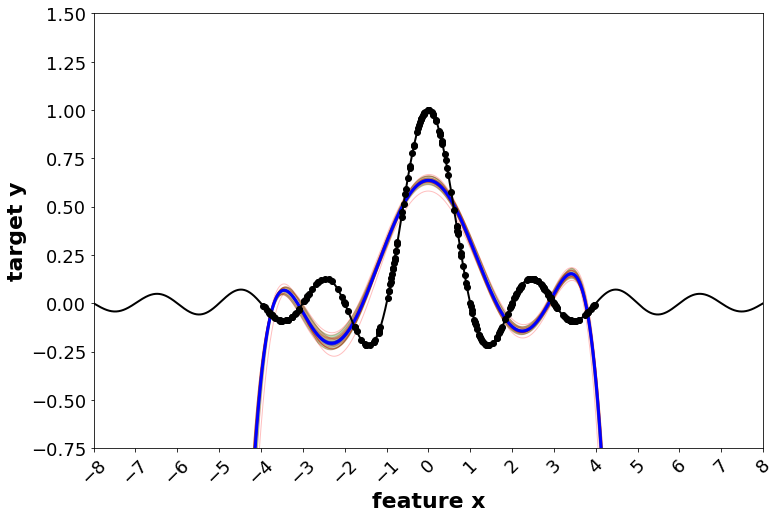

In [17]:
#generate a dens mesh
xmin=-8
xmax=8
Npts=2001
xPred=np.linspace((xmin,),(xmax,),Npts)
yExact=np.sinc(xPred).ravel()
#yExact=np.sin(xPred).ravel()

yAvg=np.zeros(Npts)
CIlow=np.zeros(Npts)
CIhigh=np.zeros(Npts)
Qlow=np.zeros(Npts)
Qhigh=np.zeros(Npts)
# and predict
all_yPred=list()
yPred2D=np.zeros((Nmodels,Npts))
cnt=-1
for clfrbf in  models:
    cnt+=1
    yPred=clfrbf.predict(xPred)
    all_yPred.append(yPred)
    yPred2D[cnt]=yPred
    # The mean squared error (MAE) and The coefficient of determination R²: 1 is perfect prediction
    #print('MAE: %.3f    R²: %.3f' % (mean_squared_error(yExact, yPred), r2_score(yExact, yPred)))

for i in range(Npts):
    yAvg[i], CIlow[i], CIhigh[i], Qlow[i], Qhigh[i]= mean_confidence_interval(yPred2D[:,i],confidence=0.9)
    #print(yAvg[i], CIlow[i], CIhigh[i]," ",yPred2D[1:5,i])
    
#print("TYPE:" , type(xPred)," shape:",xPred.shape)
    
# Plot outputs
plt.figure(figsize=(12,8))
for yPred in all_yPred:
    plt.plot(xPred, yPred,   color='red'  ,linewidth=1, zorder=-1, alpha=0.25)

plt.fill_between(xPred.ravel(), CIlow, CIhigh, color='blue', zorder=0, alpha=.5)
plt.fill_between(xPred.ravel(), Qlow, Qhigh, color='green', zorder=0, alpha=.25)
plt.plot(xPred, yAvg,  color='blue',linewidth=3, zorder=0)

plt.plot(xPred, yExact,  color='black',linewidth=2, zorder=0)
plt.scatter(x, y,  color='black', zorder=1)

plt.axis([xmin,xmax,-0.75,1.5])
step=(xmax-xmin)/11.0
Xlst=list()
for a in np.arange(math.floor(xmin),math.ceil(xmax)+1,1.0):
    Xlst.append(a)
plt.xticks(Xlst,rotation=45,fontsize=18)
#plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
plt.yticks([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1.0,1.25,1.5],fontsize=18)
plt.xlabel("feature x",fontsize=22,fontweight="bold")
plt.ylabel("target y",fontsize=22,fontweight="bold")

plt.show()

In [18]:
#sklearn gridsearch
#CrossVal=LeaveOneOut()
CrossVal=KFold(n_splits = 5, shuffle = True)
params=dict()
Gamma=[1.0e-6,1.0e-5,1.0e-4,1.0e-3,1.0e-2,0.1,1.0,10.0,100.0,1.0e3,1.0e4,1.0e5,1.0e6]
#Gamma=[1]
#Factors=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
Factors=np.array([1,2,3,4,5,6,7,8,9])
GammaDens=list()
for g in Gamma:
    GammaDens.extend(Factors*g)

ptune='gamma'   # gamma(float), c(float) or d (int)
scalename='log' #"linear", "log", "symlog", "logit",
#ptune='d'   # gamma(float), c(float) or d (int)
#scalename='linear' #"linear", "log", "symlog", "logit",


params[ptune]=GammaDens

CVmodels=list()
scoreX = GammaDens
scoreY=np.zeros((Nmodels,len(GammaDens)))
for i in range(Nmodels):
    print(i,",",end=" ")
    mod=models[i]
    CVmodel = GridSearchCV(
                mod, # our estimator
                param_grid=params, # dictionary with our possible hyper-parameters
                scoring='neg_mean_squared_error', #This gives the same type of scoring as the lasso CV
                n_jobs=4,
                cv=CrossVal,
                error_score=np.nan, # if set to raise it throws a error in case one point dies, now it throws a warning "FitFailedWarning"
                return_train_score=True, # why would we not be interested in the result of the training scores?
                )
    CVmodel.fit(datasets_x[i],datasets_y[i])
    scoreYi = np.array(CVmodel.cv_results_['mean_test_score']*-1.0)
    scoreY[i] = scoreYi
    CVmodels.append(CVmodel)


0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 

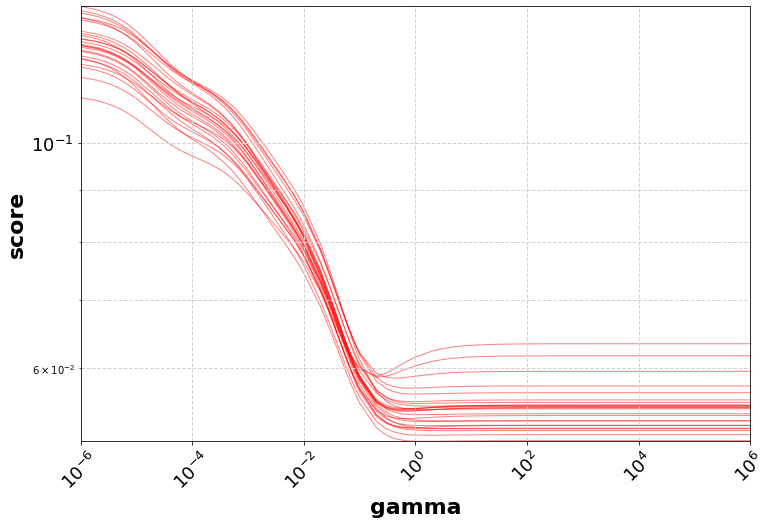

In [19]:
#generate a dens mesh
xmin=np.min(GammaDens)
xmax=np.max(GammaDens)
ymin=np.min(scoreY)
ymax=np.max(scoreY)

plt.figure(figsize=(12,8))

for yScore in scoreY:
    col='red'
    if (yScore[0]<yScore[-1]):
        col='blue'
    plt.plot(scoreX, yScore,   color=col  ,linewidth=1, zorder=-1, alpha=0.5)

#plt.plot(scoreX1, scoreY1,  color='black',linewidth=2)
#plt.plot(scoreX2, scoreY2,  color='blue',linewidth=2)

plt.xscale("log")#scalename)
plt.yscale("log")
plt.axis([1.0e-6,1.0e6,ymin,ymax])
plt.xticks(rotation=45,fontsize=18)
plt.yticks(fontsize=18)
#plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
plt.xlabel(ptune,fontsize=22,fontweight="bold")
plt.ylabel("score",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)

plt.show()